# Objective: Retrieving a simulated dataset

- scPOST is a simulation framework that estimates a study design's power to detect differentially abundant cell states (e.g. an expansion of a cell state in disease samples compared to healthy). 
- scPOST allows users to control the simulated data's characteristics, including: effect size, the number of samples, the number of cells per sample, the batch multiplexing structure, and the magnitude of simulated noise. 
- Users may retrieve simulated datasets (without performing association testing) to be used in multiple analyses

Here, we'll simulate a realistic dataset by using a rheumatoid arthritis (RA) dataset described in Zhang F, Wei K, Slowikowski K, Fonseka C, Rao DA, *et al.*, *Nature Immunol* (2020). The metadata and PC embeddings for this batch-corrected dataset is provided in the pre-loaded data: ra_HarmObj.

In this tutorial, we'll:
- Retrieve the simulated dataset and visuallize how it compares to the original input data
- See how cf_scale affects the observed fold-change in a cell state between cases/ctrls

## Load packages

In [1]:
suppressPackageStartupMessages({
    # imports for analyses
    library(scpost)
    library(dplyr)
    
    # imports for figures
    library(ggplot2)
    library(RColorBrewer)
    library(patchwork)
})

fig.size <- function (height, width) {
    options(repr.plot.height = height, repr.plot.width = width)
}

## Minimum input

To simulate data, scPOST uses an input prototype dataset (such as public or pilot data). scPOST estimates two types of variation often found in multi-sample single-cell data:

1. Variation in a cell state's frequency across samples (Cell state frequency variation)
1. Variation in a cell state's gene expression. We estimate and simulate gene expression with principal components (PCs), because PCs are a summary of gene expression that also takes into account gene covariation. This also reduces computational burden.

scPOST requires the following inputs for each cell:

1. Cell state annotations (in single-cell these are often obtained from clustering algorithms, such as the Louvain method)
1. Sample annotations (the sample each cell comes from)
1. Batch annotations (if no batch information for the data is available, it is sufficient to treat every sample as it's own batch)
1. Principal component values (these are obtained from PCA)

Let's take a look at a prototype dataset that we will apply scPOST to.

In [2]:
ra_HarmObj$meta %>% str
ra_HarmObj$embeddings %>% head(2)

'data.frame':	5265 obs. of  11 variables:
 $ UMAP1      : num  5.62 8.12 5.62 4.77 6.4 ...
 $ UMAP2      : num  8.79 9.33 8.94 9.74 9.27 ...
 $ CellID     : chr  "S006_L1Q1_A03" "S006_L1Q1_A05" "S006_L1Q1_A07" "S006_L1Q1_A09" ...
 $ sample     : Factor w/ 21 levels "300-0122","300-0153",..: 18 18 18 18 18 18 18 18 18 18 ...
 $ batch      : Factor w/ 24 levels "S006","S010",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ disease    : chr  "OA" "OA" "OA" "OA" ...
 $ nUMI       : int  2728 4074 2409 3456 2445 1920 3248 2469 1574 3775 ...
 $ nGenes     : int  1239 1673 1305 1607 1362 978 1367 1159 808 1854 ...
 $ celltype   : Factor w/ 5 levels "B cell","Empty",..: 5 5 5 5 5 5 5 5 5 5 ...
 $ preHarmClus: Factor w/ 16 levels "0","1","2","3",..: 4 4 4 4 4 6 4 6 7 4 ...
 $ harmClus   : Factor w/ 12 levels "0","1","2","3",..: 1 5 1 1 1 5 1 5 1 1 ...


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
S006_L1Q1_A03,11.57628,6.304524,-3.532067,-2.3212458,-4.534631,4.423516,1.226113,0.6364615,0.18457875,-1.742039,-0.4326295,0.7424086,2.85007198,-0.5497023,-0.05773964,1.1564199,0.04095544,1.424328,-0.7622679,0.5349482
S006_L1Q1_A05,13.65466,6.387232,-8.760231,0.8590661,1.222178,-1.380863,-1.815533,-3.7155236,0.01938719,-2.097043,-2.4153602,0.4064317,-0.05631964,2.5217680,-1.15868534,0.9470168,1.45416877,1.212025,0.4820971,-3.8591148


In the metadata, we have:

- Cell state annotations (harmClus)
- Sample annotations (sample)
- Batch annotations (batch)

In the embeddings, we have:

- Principal component values for 20 PCs

# Step 1: Parameter estimation

In [3]:
system.time({
    ra_freqEstimates <- estimateFreqVar(meta = ra_HarmObj$meta, clusCol = 'harmClus', sampleCol = 'sample', logCov = TRUE)
})

   user  system elapsed 
  0.246   0.000   0.267 

In [4]:
system.time({
    ra_pcEstimates <- estimatePCVar(pca = ra_HarmObj$embeddings, npcs = 20, meta = ra_HarmObj$meta, clusCol = 'harmClus',
                                    sampleCol = 'sample', batchCol = 'batch')
})

   user  system elapsed 
  9.893   0.122  10.165 

# Step 2: Simulate dataset

Here, we'll simulate a realistic dataset like we did in the "Getting Started" tutorial. However, we now use the simDataset.base function, which simulates a dataset based on the estimated parameters; it does not perform association testing like the simDataset.withMASC function. 

In [5]:
set.seed(23)

# Set the number of samples, number of cells per sample, and create batch structure
ncases <- 17
nctrls <- 4
nbatches <- 4
batchStructure <- distribSamples(ncases = ncases, nctrls = nctrls, nbatches = nbatches)
ncells <- rep(250, times = ncases + nctrls)
names(ncells) <- batchStructure$sample_names

Next, we'll set up a parameter table with the "createParamTable" function that we'll use to run multiple simulations: 
- We'll simulate realistic levels of variation by setting "b_scale", "s_scale", and "cf_scale" equal to 1. 
- We'll won't induce a fold-change, so we'll set fc = 1, and just choose a random cluster to to induce the fold-change into
- We'll set up a folder where we will save our results

In [6]:
params <- createParamTable(
    nreps = 1,
    clus = "clus0",
    fc = 1,
    ncases = ncases,
    nctrls = nctrls,
    nbatches = nbatches,
    b_scale = 1,
    s_scale = 1,
    cf_scale = 1,
    res_use = 0.6,
    cond_induce = "cases",
    save_path = file.path(getwd(), "scpostSims/retrievingSimulations")
)

params %>% head(2)

,rep,ncases,nctrls,nbatches,b_scale,s_scale,cf_scale,clus,fc,res_use,save_path,cond_induce,seed
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<chr>,<int>
1,1,17,4,4,1,1,1,clus0,1,0.6,/data/srlab1/nmillard/scpost/vignettes/scpostSims/retrievingSimulations,cases,1294557932


Here, we want to return the dataset PC embeddings, so we set the "returnPCs" argument to TRUE. We do not need to re-cluster the simulated data, so we set the "clusterData" argument to FALSE.

In [7]:
suppressWarnings({
    lapply(seq(nrow(params)), function(x){
            simDataset.base(
                save_path = params[x, 'save_path'],
                rep = params[x, 'rep'],
                seed = params[x, 'seed'],
                ncases = params[x, 'ncases'],
                nctrls = params[x, 'nctrls'],
                nbatches = params[x, 'nbatches'],
                batchStructure = batchStructure,
                ncells = ncells,
                centroids = ra_pcEstimates$centroids,
                pc_cov_list = ra_pcEstimates$pc_cov_list,
                batch_vars = ra_pcEstimates$batch_vars,
                b_scale = params[x, 'b_scale'],
                sample_vars = ra_pcEstimates$sample_vars,
                s_scale = params[x, 's_scale'],
                cfcov = ra_freqEstimates$cfcov,
                cf_scale = params[x, 'cf_scale'],
                meanFreqs = ra_freqEstimates$meanFreq,
                clus = params[x, 'clus'],
                fc = params[x, 'fc'],
                cond_induce = params[x, 'cond_induce'],
                res_use = params[x, 'res_use'], 
                mc.cores = 1,
                clusterData = FALSE,
                returnPCs = TRUE
            )
    })
})

Simulated dataset at 2021-07-21 10:09:34



[[1]]
NULL

# Retrieve simulated dataset

In [29]:
dir <- file.path(getwd(), "scpostSims/retrievingSimulations/")
sim_filenames <- list.files(path = dir,
                            full.names = T) %>% basename
sim_data <- lapply(sim_filenames, function(x){
        readRDS(file.path(dir, x))
})
sim_data[[1]] %>% str

List of 2
 $ meta   :'data.frame':	5252 obs. of  4 variables:
  ..$ cellstate: Factor w/ 12 levels "0","1","2","3",..: 1 1 1 3 3 3 3 3 3 3 ...
  ..$ sample   : chr [1:5252] "sample19" "sample19" "sample19" "sample19" ...
  ..$ condition: chr [1:5252] "case" "case" "case" "case" ...
  ..$ batch    : chr [1:5252] "batch1" "batch1" "batch1" "batch1" ...
 $ new_pcs: num [1:5252, 1:20] 13.01 12.24 12.9 4.33 3.24 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:5252] "1" "2" "3" "4" ...
  .. ..$ : chr [1:20] "PC1" "PC2" "PC3" "PC4" ...


From the saved data, we see that we simulated 5,252 cells. Let's visualize how the PC embeddings of our simulated dataset compare to the original data

Now let's combine our simulated data with the real data

In [10]:
ra_pcs <- cbind.data.frame(ra_HarmObj$meta, ra_HarmObj$embeddings) %>% dplyr::select(c(harmClus, sample, batch,
                                                                                        paste0("PC", 1:20)))
sim_pcs <- cbind.data.frame(sim_data[[1]]$meta, sim_data[[1]]$new_pcs) %>% dplyr::select(-condition)
colnames(ra_pcs) <- c("cellstate", "sample", "batch", paste0("PC", 1:20))
colnames(sim_pcs) <- c("cellstate", "sample", "batch", paste0("PC", 1:20))

comb_pcs <- rbind.data.frame(ra_pcs, sim_pcs)
comb_pcs$dataset <- c(rep("Real", nrow(ra_pcs)), rep("Sim", nrow(sim_pcs)))

comb_pcs %>% head(2)

,cellstate,sample,batch,PC1,PC2,PC3,PC4,PC5,PC6,PC7,⋯,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,dataset
,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
2,0,301-0159,S006,11.57628,6.304524,-3.532067,-2.3212458,-4.534631,4.423516,1.226113,⋯,0.7424086,2.85007198,-0.5497023,-0.05773964,1.1564199,0.04095544,1.424328,-0.7622679,0.5349482,Real
3,4,301-0159,S006,13.65466,6.387232,-8.760231,0.8590661,1.222178,-1.380863,-1.815533,⋯,0.4064317,-0.05631964,2.5217680,-1.15868534,0.9470168,1.45416877,1.212025,0.4820971,-3.8591148,Real


## Visualize the real input RA dataset with the simulated dataset

In [11]:
system.time({
    umap_comb <- uwot::umap(comb_pcs %>% dplyr::select(paste0("PC", 1:20)))
    colnames(umap_comb) <- paste0("UMAP", 1:2)
    plot_comb <- cbind.data.frame(umap_comb, comb_pcs)
})

   user  system elapsed 
 13.551   2.276  11.639 

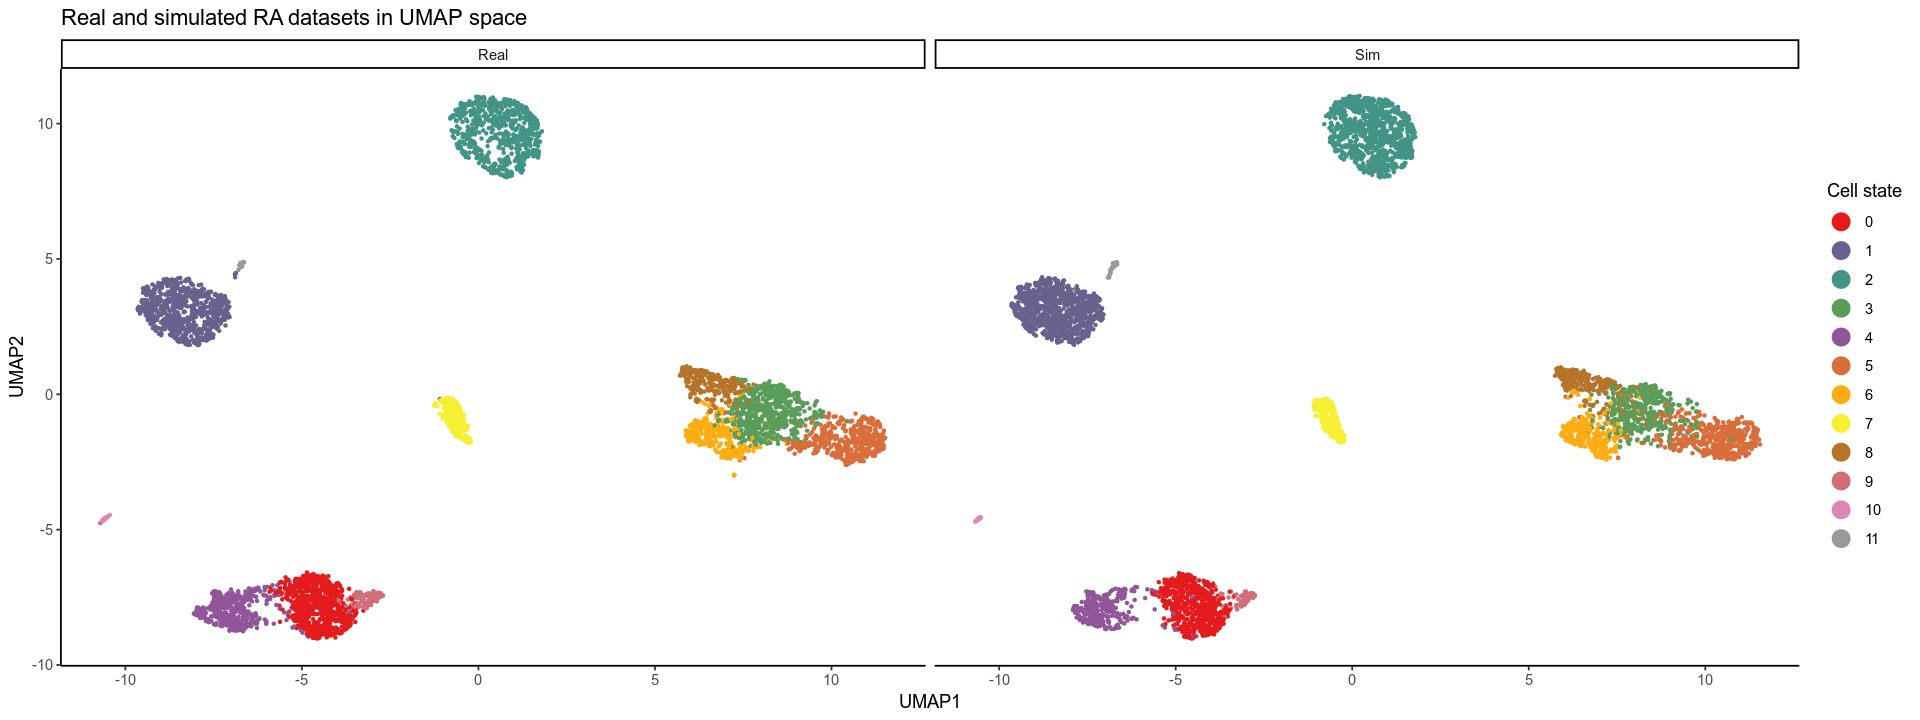

In [20]:
# create color palette
plotPal <- colorRampPalette(brewer.pal(9, 'Set1'))

fig.size(6,16)
plot_comb %>% sample_frac %>% ggplot(aes(x = UMAP1, y = UMAP2, col = cellstate)) +
    geom_point(size = 0.6) +
    theme_classic() +
    labs(title = 'Real and simulated RA datasets in UMAP space', col = 'Cell state') +
    scale_color_manual(values = plotPal(plot_comb$cellstate %>% unique %>% length)) +
    guides(col = guide_legend(override.aes = list(stroke = 1, alpha = 1, shape = 19, size = 4))) +
    facet_wrap(~dataset)

It looks like the simulated cells were placed into a similar PC space when compared to the real data. A notable difference between the simulated dataset and the input real data is the number of each state. This is because the simulated dataset also generates cell state frequency distributions for each simulated sample, which will be different from the real data. For example, our simulated dataset generated more cells as cell state 2, but fewer cells as cell state 3.

In [21]:
plot_comb %>% filter(dataset == 'Real') %>% pull(cellstate) %>% table
plot_comb %>% filter(dataset == 'Sim') %>% pull(cellstate) %>% table

.
  0   1   2   3   4   5   6   7   8   9  10  11 
824 805 752 694 549 508 359 308 284 107  45  30 

.
   0    1    2    3    4    5    6    7    8    9   10   11 
 610 1041 1100  481  323  565  360  278  299   89   38   68 

# Retrieving the observed fold-change in a simulated dataset

scPOST simulates cell state frequency distributions for each simulated sample. Because our model includes variance in these distributions, the actual observed fold-change may be slightly different from the fold-change we wanted to induce. This is how cell state frequency variation contributes to a decrease in power; if the variance is high, random sampling can mask the true fold-change by resulting in a smaller observed fold-change.

Let's simulate a few datasets with no cell state frequency variation, and then a few with realistic levels of cell state frequency variation. Then, we can check what the observed fold-change is. We do this by setting "cf_scale" to 0. A realistic level of variation (as estimated from the real data) would be "cf_scale" set to 1.

In [22]:
set.seed(23)

# Set the number of samples, number of cells per sample, and create batch structure
ncases <- 10
nctrls <- 10
nbatches <- 4
batchStructure <- distribSamples(ncases = ncases, nctrls = nctrls, nbatches = nbatches)
ncells <- rep(250, times = ncases + nctrls)
names(ncells) <- batchStructure$sample_names

Next, we'll set up a parameter table with the "createParamTable" function that we'll use to run multiple simulations: 
- We'll simulate realistic levels of variation by setting "b_scale", "s_scale". We'll simulate either 0 or realistic levels of cell state frequency variation by setting and "cf_scale" equal to 0 or 1 respectively. 
- We'll induce a fold-change of 2 in "clus0"
- We'll set up a folder where we will save our results

With the following parameter table, we'll run:

- 5 simulations with cf_scale = 0
- 5 simulations with cf_scale = 1

In [23]:
params <- createParamTable(
    nreps = 5,
    clus = "clus0",
    fc = 2,
    ncases = ncases,
    nctrls = nctrls,
    nbatches = nbatches,
    b_scale = 1,
    s_scale = 1,
    cf_scale = c(0,1),
    res_use = 0.6,
    cond_induce = "cases",
    save_path = file.path(getwd(), "scpostSims/retrievingCFscale")
)

params %>% dim
params %>% head(2)

[1] 10 13

,rep,ncases,nctrls,nbatches,b_scale,s_scale,cf_scale,clus,fc,res_use,save_path,cond_induce,seed
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<chr>,<int>
1,1,10,10,4,1,1,0,clus0,2,0.6,/data/srlab1/nmillard/scpost/vignettes/scpostSims/retrievingCFscale,cases,265763406
2,2,10,10,4,1,1,0,clus0,2,0.6,/data/srlab1/nmillard/scpost/vignettes/scpostSims/retrievingCFscale,cases,1113800433


Here, we want to return the dataset PC embeddings, so we set the "returnPCs" argument to TRUE. We do not need to re-cluster the simulated data, so we set the "clusterData" argument to FALSE.

In [24]:
suppressWarnings({
    lapply(seq(nrow(params)), function(x){
            simDataset.base(
                save_path = params[x, 'save_path'],
                rep = params[x, 'rep'],
                seed = params[x, 'seed'],
                ncases = params[x, 'ncases'],
                nctrls = params[x, 'nctrls'],
                nbatches = params[x, 'nbatches'],
                batchStructure = batchStructure,
                ncells = ncells,
                centroids = ra_pcEstimates$centroids,
                pc_cov_list = ra_pcEstimates$pc_cov_list,
                batch_vars = ra_pcEstimates$batch_vars,
                b_scale = params[x, 'b_scale'],
                sample_vars = ra_pcEstimates$sample_vars,
                s_scale = params[x, 's_scale'],
                cfcov = ra_freqEstimates$cfcov,
                cf_scale = params[x, 'cf_scale'],
                meanFreqs = ra_freqEstimates$meanFreq,
                clus = params[x, 'clus'],
                fc = params[x, 'fc'],
                cond_induce = params[x, 'cond_induce'],
                res_use = params[x, 'res_use'], 
                mc.cores = 1,
                clusterData = FALSE,
                returnPCs = TRUE
            )
    })
})

Simulated dataset at 2021-07-21 10:11:52

Simulated dataset at 2021-07-21 10:11:54

Simulated dataset at 2021-07-21 10:11:55

Simulated dataset at 2021-07-21 10:11:57

Simulated dataset at 2021-07-21 10:11:59

Simulated dataset at 2021-07-21 10:12:00

Simulated dataset at 2021-07-21 10:12:02

Simulated dataset at 2021-07-21 10:12:03

Simulated dataset at 2021-07-21 10:12:05

Simulated dataset at 2021-07-21 10:12:06



[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL

[[6]]
NULL

[[7]]
NULL

[[8]]
NULL

[[9]]
NULL

[[10]]
NULL

## Retrieve simulated datasets

In [25]:
dir <- file.path(getwd(), "scpostSims/retrievingCFscale/")
sim_filenames <- list.files(path = dir,
                            full.names = T,) %>% basename
sim_data <- lapply(sim_filenames, function(x){
        readRDS(file.path(dir, x))[["meta"]]
})

Now let's see what our observed fold-changes are. We induced a fold-change of 2 in cell state 0. When cf_scale = 0 (zero cell state frequency variation), we should see an exact fold-change of 2 in cell state 0, while we'll see some variance when cf_scale = 1

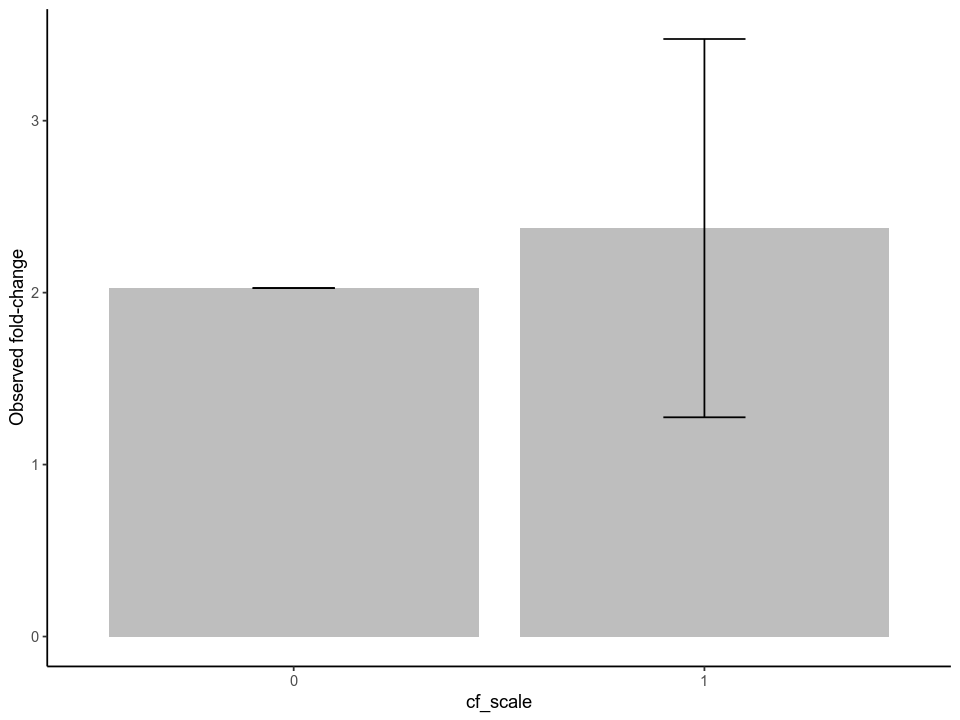

In [27]:
getFC <- function(meta_data, cluster){
    tbl <- meta_data %>% subset(cellstate == paste0(cluster))
    tbl %<>% group_by(condition) %>% summarize(freq = dplyr::n(), .groups = 'drop')
    fc <- tbl %>% summarize(obs_fc = freq[condition == 'case'] / freq[condition == 'ctrl'], .groups = 'drop') %>% dplyr::pull(obs_fc)
    return(fc)
}

obs_fcs <- data.frame(obs_fc = sapply(sim_data, function(x){
    getFC(x, cluster = 0)
}))
obs_fcs$cf_scale <- c(rep(0, 5), rep(1, 5))

mean_fcs <- obs_fcs %>% group_by(cf_scale) %>% summarise(mean_obs = mean(obs_fc), sd = sd(obs_fc), .groups = 'drop') %>% data.frame
mean_fcs$cf_scale <- factor(mean_fcs$cf_scale, levels = c(0,1))

fig.size(6,8)
mean_fcs %>% ggplot(aes(x = cf_scale, y = mean_obs)) +
    geom_bar(stat = 'identity', fill = 'gray') +
    geom_errorbar(aes(ymin = mean_obs - sd, ymax = mean_obs + sd), width = 0.2) +
    theme_classic() +
    labs(x = 'cf_scale', y = 'Observed fold-change')

As expected, when cf_scale = 0, there is no variance. However, when we have a realistic level of cell state frequency variation, we do see some variance. If variance is higher, it could result in decreased power, because the observed fold-change might be lower than the true fold-change. Over more replicates, our average observed fold-changes would begin to converge to 2.

# Session information

In [28]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server release 6.5 (Santiago)

Matrix products: default
BLAS/LAPACK: /PHShome/nm455/miniconda3/envs/paraR4.0.3/lib/libopenblasp-r0.3.12.so

Random number generation:
 RNG:     L'Ecuyer-CMRG 
 Normal:  Inversion 
 Sample:  Rejection 
 
locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] patchwork_1.1.1    RColorBrewer_1.1-2 ggplot2_3.3.3      dplyr_1.0.4       
[5] scpost_1.0        

loaded via a namespace (and not attached):
  [1] Seurat_4.0.0  